In [2]:
import sys
sys.executable

import numpy as np
import pandas as pd
import geopandas as gpd
from inequality.theil import Theil
import libpysal
import matplotlib.pyplot as plt
import seaborn as sns
import inequality

In [3]:
import os
os.getcwd()

data_pth = "../../../../frontend/data/"

In [4]:
df = pd.read_json(f"{data_pth}w_ind.json")
df.head()

,county,2015,2016,2017,2018,2019,2020,2021,region
0,Alt Camp,173693.3086,157520.4461,166033.4572,194407.0632,215992.5651,197128.2528,199018.5874,Catalunya
1,Alt Empordà,22581.7378,24047.8645,25277.6141,22261.4138,25435.9352,22285.7143,28485.2725,Catalunya
2,Alt Penedès,281392.9174,254893.7605,264954.4688,292792.5801,278435.0759,255016.8634,262111.2985,Catalunya
3,Alt Urgell,3327.3481,1495.1657,1805.8051,1192.8127,2085.0035,1387.6987,1315.1348,Pyrenees
4,Alta Ribagorça,2002.3419,2843.0913,1297.4239,1355.9719,1634.6604,1269.3208,1028.1030,Pyrenees


In [5]:
gdf = gpd.read_file(f"{data_pth}geometry_counties_all.geojson")

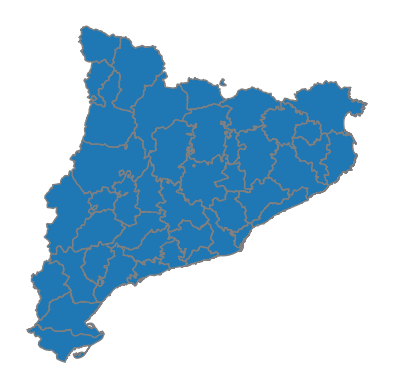

In [6]:
ax = gdf.plot(edgecolor = "grey")
ax.set_axis_off()

In [7]:
gdf.head()

,county,geometry
0,Alt Camp,"MULTIPOLYGON (((1.47594 41.47798, 1.47959 41.4..."
1,Alt Empordà,"MULTIPOLYGON (((3.22338 42.23682, 3.22336 42.2..."
2,Alt Penedès,"MULTIPOLYGON (((1.6169 41.5126, 1.61712 41.512..."
3,Alt Urgell,"MULTIPOLYGON (((1.31941 41.99157, 1.32141 41.9..."
4,Alta Ribagorça,"MULTIPOLYGON (((0.8795 42.6314, 0.87967 42.631..."


In [8]:
w_ind = gdf.merge(df, on="county", how="left")
w_ind.head()

,county,geometry,2015,2016,2017,2018,2019,2020,2021,region
0,Alt Camp,"MULTIPOLYGON (((1.47594 41.47798, 1.47959 41.4...",173693.3086,157520.4461,166033.4572,194407.0632,215992.5651,197128.2528,199018.5874,Catalunya
1,Alt Empordà,"MULTIPOLYGON (((3.22338 42.23682, 3.22336 42.2...",22581.7378,24047.8645,25277.6141,22261.4138,25435.9352,22285.7143,28485.2725,Catalunya
2,Alt Penedès,"MULTIPOLYGON (((1.6169 41.5126, 1.61712 41.512...",281392.9174,254893.7605,264954.4688,292792.5801,278435.0759,255016.8634,262111.2985,Catalunya
3,Alt Urgell,"MULTIPOLYGON (((1.31941 41.99157, 1.32141 41.9...",3327.3481,1495.1657,1805.8051,1192.8127,2085.0035,1387.6987,1315.1348,Pyrenees
4,Alta Ribagorça,"MULTIPOLYGON (((0.8795 42.6314, 0.87967 42.631...",2002.3419,2843.0913,1297.4239,1355.9719,1634.6604,1269.3208,1028.1030,Pyrenees


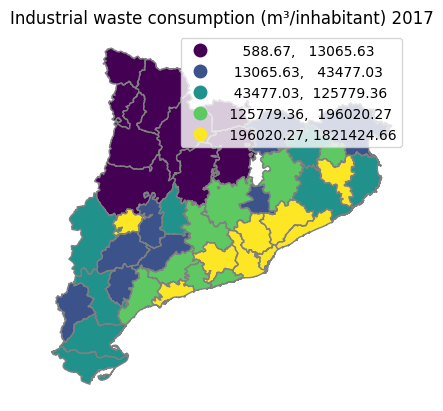

In [9]:
ax =w_ind.plot(
    column="2016", k=5, scheme="Quantiles", edgecolor="grey", legend=True
)
ax.set_axis_off()
ax.set_title("Industrial waste consumption (m³/inhabitant) 2017");

In [10]:
theil_2016 = inequality.theil.Theil(w_ind["2016"].dropna())
theil_2016.T

0.9720856990273093

In [11]:
inequality.theil.TheilD

inequality.theil.TheilD

In [12]:
regimes = w_ind["region"].astype(str)

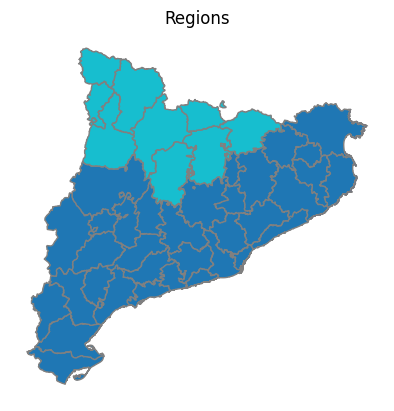

In [13]:
ax = w_ind.plot(column="region", categorical=True, edgecolor="grey")
ax.set_title("Regions")
ax.set_axis_off()


In [14]:
np.random.seed(12345)
ts = inequality.theil.TheilD(w_ind["2016"].dropna(), regimes)

In [15]:
ts.T

0.9720856990273093

In [16]:
ts.bg

array([0.18175278])

In [17]:
ts.wg

array([0.79033292])

In [18]:
ts.bg[0] / ts.T

np.float64(0.1869719689634436)

In [19]:
np.random.seed(10)

In [20]:
mask = w_ind["2016"].notna()

values =w_ind.loc[mask, "2016"]
regs   = w_ind.loc[mask, "region"].astype(str)

ts = inequality.theil.TheilDSim(values, regs, permutations=999)

In [21]:
ts.bg_pvalue

array([0.022])

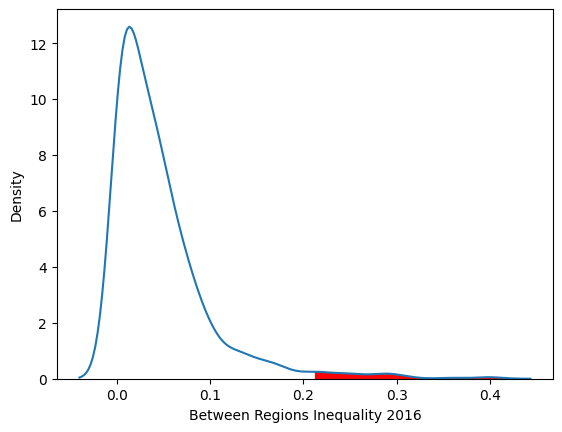

In [22]:
kdeplot = sns.kdeplot(ts.bg, fill=False, legend=False)
x_vals = kdeplot.lines[0].get_xdata()
y_vals = kdeplot.lines[0].get_ydata()
plt.fill_between(x_vals, y_vals, where=(x_vals > ts.bg[0]), color="red")
plt.xlabel("Between Regions Inequality 2016");

In [23]:
years = range(2015, 2021)
np.random.seed(12345)

ts = [inequality.theil.Theil(w_ind[f"{year}"]).T for year in years]

regimes = w_ind["region"]
tsd = [
    inequality.theil.TheilDSim(
        w_ind[f"{year}"].dropna(),
        regimes[w_ind[f"{year}"].notna()],  
        permutations=999
    )
    for year in years
]
p = np.array([(tsdi.bg_pvalue[0], tsdi.T, tsdi.results[0].bg[0]) for tsdi in tsd])

In [24]:
rdf = pd.DataFrame(data=p, columns=["p-value", "Theil", "BG"])
rdf["BGshare"] = rdf.BG / rdf.Theil
rdf["Year"] = years

rdf.tail()

,p-value,Theil,BG,BGshare,Year
1,0.018,0.972086,0.211420,0.217491,2016
2,0.016,0.959794,0.208144,0.216863,2017
3,0.014,0.969648,0.207362,0.213853,2018
4,0.017,0.966410,0.208054,0.215286,2019
5,0.015,0.926859,0.210012,0.226585,2020


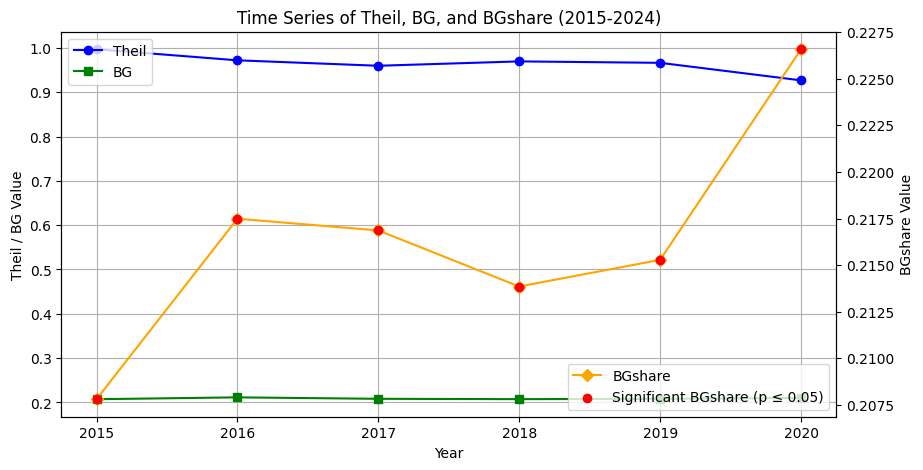

In [25]:
significant_points = rdf[rdf["p-value"] <= 0.05]
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(rdf["Year"], rdf["Theil"], marker="o", label="Theil", color="blue")
ax1.plot(rdf["Year"], rdf["BG"], marker="s", label="BG", color="green")
ax1.set_xlabel("Year")
ax1.set_ylabel("Theil / BG Value")
ax1.set_title("Time Series of Theil, BG, and BGshare (2015-2024)")
ax2 = ax1.twinx()
ax2.plot(rdf["Year"], rdf["BGshare"], marker="D", label="BGshare", color="orange")
ax2.scatter(
    significant_points["Year"],
    significant_points["BGshare"],
    color="red",
    label="Significant BGshare (p ≤ 0.05)",
    zorder=3,
)

ax2.set_ylabel("BGshare Value")
ax1.legend(loc="upper left")
ax2.legend(loc="lower right")
ax1.grid(True)
plt.show()